In [8]:
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from utils import generate_dmatrix

In [6]:
%matplotlib inline
rcParams['figure.figsize'] = 12, 4

In [29]:
def fit_model(model, data, use_cv=True, cv_folds=5, early_stopping_rounds=50, eval_feature_importance=False):
    """
    Parameters
    ----------
    model : XGBClassifier
        Model with parameters pre-set
    data : dict[np.ndarray]
        Dict with the keys 'train_x', 'train_y', 'test_x', 'test_y' for the
        appropriate arrays.
    use_cv : bool
        Whether to use CV for setting the number of estimators. Default True.
    cv_folds : int
        Number of folds for the CV. Default 5.
    early_stopping_rounds : int
        How many rounds the model must train without improvement before
        stopping early.
    eval_feature_importance : bool
        If True, a feature importance plot is generated. Default False.
    """
    train_x = data['train_x']
    train_y = data['train_y']
    test_x = data['test_x']
    test_y = data['test_y']
    train_y[train_y == -1] = 0
    test_y[test_y == -1] = 0
    if use_cv:
        dmatrix = generate_dmatrix(train_x, train_y)
        xgb_params = model.get_xgb_params()
        nbr = model.get_params()['n_estimators']
        cv_results = xgb.cv(xgb_params, dmatrix, num_boost_round=nbr, metrics='logloss',
                            early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        n_est = cv_results.shape[0]
        model.set_params(n_estimators=n_est)
        print(f'[INFO] N. of estimators for this learning rate: {n_est}')
    
    # Fit model on data
    model.fit(train_x, train_y, eval_metric='logloss')
    # Evaluate model
    train_pred = model.predict(train_x)
    train_predprob = model.predict_proba(train_x)[:, 1]
    test_pred = model.predict(test_x)
    test_predprob = model.predict_proba(test_x)[:, 1]
    # Print model report
    print('Model Report\n============')
    print(f'Accuracy (train) : {metrics.accuracy_score(train_y, train_pred):.4g}')
    print(f'AUC Score (train) : {metrics.roc_auc_score(train_y, train_predprob):f}')
    print(f'Accuracy (test) : {metrics.accuracy_score(test_y, test_pred):.4g}')
    print(f'AUC Score (test) : {metrics.roc_auc_score(test_y, test_predprob):f}')
    # Evaluate feature importance
    if eval_feature_importance:
        feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
        plt.clf()
    return model

In [10]:
from sklearn.model_selection import train_test_split

from benchmark_tests.load_benchmark_datasets import load_dataset_m41
from load_partitions import load_partitions

In [12]:
m41_x, m41_y = load_dataset_m41()
m41_train_x, m41_test_x, m41_train_y, m41_test_y = train_test_split(
    m41_x, m41_y, stratify=m41_y, test_size=0.3, random_state=42
)
m41_data = {'train_x': m41_train_x,
            'train_y': m41_train_y,
            'test_x': m41_test_x,
            'test_y': m41_test_y}

In [13]:
def get_iris_data(dataset_name, partition=1):
    train_x, train_y, _, _, test_x, test_y, _, _ = load_partitions(
        dataset_name, partition, mask_value=0, scale_dataset=True)
    data = {'train_x': train_x,
            'train_y': train_y,
            'test_x': test_x,
            'test_y': test_y}
    return data

In [14]:
iris_left_24020_data = get_iris_data('left_240x20')

In [32]:
def get_iris_data_discrete(dataset_name, partition=1):
    from sklearn.preprocessing import KBinsDiscretizer
    train_x, train_y, _, _, test_x, test_y, _, _ = load_partitions(
        dataset_name, partition, mask_value=0, scale_dataset=True)
    disc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    train_x = disc.fit_transform(train_x)
    test_x = disc.transform(test_x)
    data = {'train_x': train_x,
            'train_y': train_y,
            'test_x': test_x,
            'test_y': test_y}
    return data

In [33]:
iris_left_24020_disc_data = get_iris_data_discrete('left_240x20')

D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 17 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 188 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 192 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 193 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 207 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D

## Step 1

[INFO] N. of estimators for this learning rate: 45
Model Report
Accuracy (train) : 0.9389
AUC Score (train) : 0.999460
Accuracy (test) : 0.8828
AUC Score (test) : 0.897983


D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


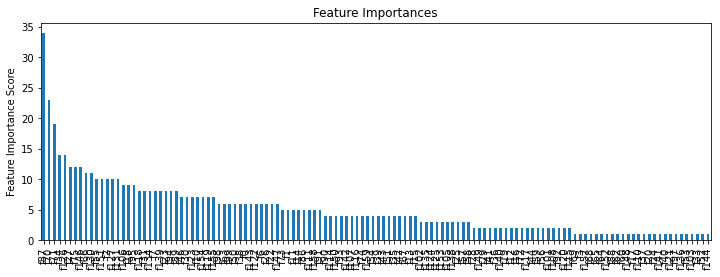

<Figure size 864x288 with 0 Axes>

In [30]:
# Using nucleotids (M41)
xgb1_nuc = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=5,
    scale_pos_weight=1,
    seed=27
)
model = fit_model(xgb1_nuc, m41_data, eval_feature_importance=True)

[INFO] N. of estimators for this learning rate: 357


D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Model Report
Accuracy (train) : 1
AUC Score (train) : 1.000000
Accuracy (test) : 0.6254
AUC Score (test) : 0.680898


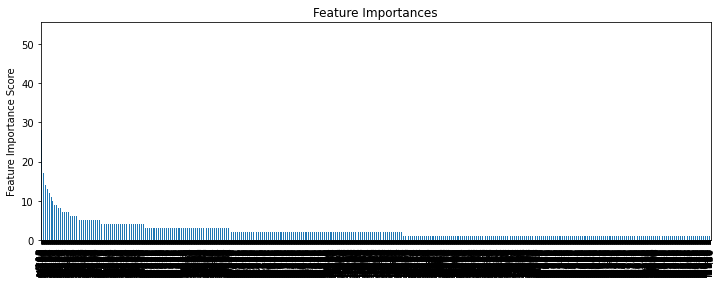

<Figure size 864x288 with 0 Axes>

In [36]:
# Using iris (left 240x20)
xgb1_iris = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=5,
    scale_pos_weight=1,
    seed=27
)
model = fit_model(xgb1_iris, iris_left_24020_data, eval_feature_importance=True)

[INFO] N. of estimators for this learning rate: 264


D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Model Report
Accuracy (train) : 0.9933
AUC Score (train) : 0.999872
Accuracy (test) : 0.6037
AUC Score (test) : 0.645295


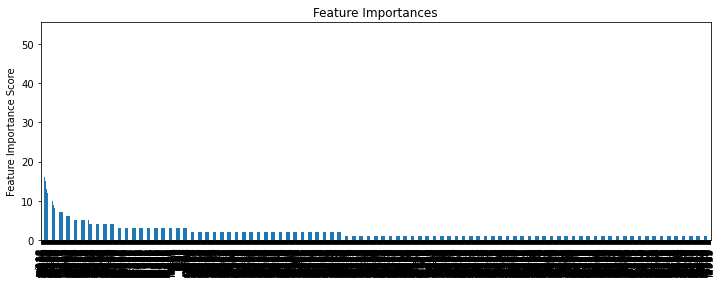

<Figure size 864x288 with 0 Axes>

In [37]:
# Using iris discrete (left 240x20)
xgb1_iris_d = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=5,
    scale_pos_weight=1,
    seed=27
)
model = fit_model(xgb1_iris_d, iris_left_24020_disc_data, eval_feature_importance=True)

In [40]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from utils import generate_dmatrix

DEFAULT_PARAMS = {
    'objective': 'binary:logistic',
    'use_label_encoder': False,
    'eval_metric': 'logloss',
}
SEED = 42


def phase_1(data: dict, lr_list, njobs: int):
    """Adjust learning rate and number of trees."""
    # Determine initial value for number of trees
    train_x = data['train_x']
    train_y = data['train_y']
    test_x = data['test_x']
    test_y = data['test_y']
    test_x, val_x, test_y, val_y = train_test_split(
        test_x, test_y, test_size=1 / 3, stratify=test_y, random_state=SEED
    )
    results = {}
    for lr in lr_list:
        # Get base number of trees from xgb native CV
        cur_results = {}
        model = XGBClassifier(
            **DEFAULT_PARAMS,
            learning_rate=lr,
            n_estimators=1000,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            nthread=njobs,
            scale_pos_weight=1,
            seed=SEED
        )
        dmatrix = generate_dmatrix(train_x, train_y)
        params = model.get_params()
        nbr = params['n_estimators']
        cv_results = xgb.cv(
            params,
            dmatrix,
            num_boost_round=nbr,
            metrics='logloss',
            early_stopping_rounds=50,
            nfold=5,
            verbose_eval=True
        )
        cur_results['cv_results'] = cv_results
        n_est = cv_results.shape[0]
        # Evaluate using these parameters
        model.set_params(
            n_estimators=n_est,
        )
        model.fit(
            train_x, train_y,
            eval_set=[(train_x, train_y), (val_x, val_y)],
            eval_metric=['error', 'logloss']
        )
        pred = model.predict(test_x)
        report = classification_report(test_y, pred, output_dict=True)
        cur_results['report'] = report
        results[lr] = cur_results
    
    return results


In [ ]:
results_iris = phase_1(iris_left_24020_data, np.arange(0.01, 0.11, 0.01), njobs=5)

[13:24:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:24:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:24:28] WARNING: C:/Users/Administrator/workspa

[92]	train-logloss:0.45922+0.00725	test-logloss:0.66707+0.01063
[93]	train-logloss:0.45741+0.00744	test-logloss:0.66697+0.01079
[94]	train-logloss:0.45567+0.00698	test-logloss:0.66696+0.01060
[95]	train-logloss:0.45376+0.00703	test-logloss:0.66690+0.01078
[96]	train-logloss:0.45184+0.00732	test-logloss:0.66668+0.01085
[97]	train-logloss:0.45027+0.00736	test-logloss:0.66682+0.01079
[98]	train-logloss:0.44850+0.00723	test-logloss:0.66662+0.01094
[99]	train-logloss:0.44654+0.00716	test-logloss:0.66655+0.01082
[100]	train-logloss:0.44474+0.00734	test-logloss:0.66662+0.01085
[101]	train-logloss:0.44302+0.00720	test-logloss:0.66647+0.01088
[102]	train-logloss:0.44121+0.00732	test-logloss:0.66634+0.01106
[103]	train-logloss:0.43944+0.00739	test-logloss:0.66642+0.01129
[104]	train-logloss:0.43798+0.00738	test-logloss:0.66625+0.01088
[105]	train-logloss:0.43648+0.00742	test-logloss:0.66604+0.01086
[106]	train-logloss:0.43489+0.00754	test-logloss:0.66588+0.01082
[107]	train-logloss:0.43326+0.007

[219]	train-logloss:0.29043+0.00749	test-logloss:0.65863+0.01973
[220]	train-logloss:0.28944+0.00756	test-logloss:0.65860+0.01973
[221]	train-logloss:0.28835+0.00760	test-logloss:0.65855+0.02007
[222]	train-logloss:0.28734+0.00753	test-logloss:0.65843+0.02023
[223]	train-logloss:0.28644+0.00759	test-logloss:0.65846+0.02039
[224]	train-logloss:0.28546+0.00745	test-logloss:0.65836+0.02036
[225]	train-logloss:0.28452+0.00754	test-logloss:0.65845+0.02043
[226]	train-logloss:0.28340+0.00768	test-logloss:0.65820+0.02053
[227]	train-logloss:0.28249+0.00756	test-logloss:0.65828+0.02041
[228]	train-logloss:0.28152+0.00751	test-logloss:0.65816+0.02049
[229]	train-logloss:0.28066+0.00747	test-logloss:0.65817+0.02054
[230]	train-logloss:0.27984+0.00750	test-logloss:0.65814+0.02060
[231]	train-logloss:0.27885+0.00743	test-logloss:0.65810+0.02075
[232]	train-logloss:0.27791+0.00735	test-logloss:0.65807+0.02087
[233]	train-logloss:0.27709+0.00732	test-logloss:0.65789+0.02089
[234]	train-logloss:0.276

[6]	validation_0-error:0.10000	validation_0-logloss:0.67195	validation_1-error:0.34000	validation_1-logloss:0.68705
[7]	validation_0-error:0.11000	validation_0-logloss:0.66902	validation_1-error:0.37500	validation_1-logloss:0.68667
[8]	validation_0-error:0.09111	validation_0-logloss:0.66555	validation_1-error:0.38500	validation_1-logloss:0.68578
[9]	validation_0-error:0.09000	validation_0-logloss:0.66294	validation_1-error:0.37500	validation_1-logloss:0.68572
[10]	validation_0-error:0.08889	validation_0-logloss:0.66074	validation_1-error:0.37500	validation_1-logloss:0.68526
[11]	validation_0-error:0.08333	validation_0-logloss:0.65812	validation_1-error:0.37500	validation_1-logloss:0.68420
[12]	validation_0-error:0.07444	validation_0-logloss:0.65565	validation_1-error:0.36500	validation_1-logloss:0.68365
[13]	validation_0-error:0.07222	validation_0-logloss:0.65358	validation_1-error:0.35000	validation_1-logloss:0.68272
[14]	validation_0-error:0.07111	validation_0-logloss:0.65147	validat

[77]	validation_0-error:0.02444	validation_0-logloss:0.51182	validation_1-error:0.38500	validation_1-logloss:0.66033
[78]	validation_0-error:0.02333	validation_0-logloss:0.50970	validation_1-error:0.38500	validation_1-logloss:0.65998
[79]	validation_0-error:0.02333	validation_0-logloss:0.50805	validation_1-error:0.38500	validation_1-logloss:0.65974
[80]	validation_0-error:0.02444	validation_0-logloss:0.50596	validation_1-error:0.39000	validation_1-logloss:0.65975
[81]	validation_0-error:0.02444	validation_0-logloss:0.50431	validation_1-error:0.38500	validation_1-logloss:0.65947
[82]	validation_0-error:0.02333	validation_0-logloss:0.50268	validation_1-error:0.38500	validation_1-logloss:0.65907
[83]	validation_0-error:0.02444	validation_0-logloss:0.50078	validation_1-error:0.39500	validation_1-logloss:0.65875
[84]	validation_0-error:0.02333	validation_0-logloss:0.49837	validation_1-error:0.38500	validation_1-logloss:0.65896
[85]	validation_0-error:0.02444	validation_0-logloss:0.49717	val

[147]	validation_0-error:0.00444	validation_0-logloss:0.40367	validation_1-error:0.39000	validation_1-logloss:0.64903
[148]	validation_0-error:0.00444	validation_0-logloss:0.40267	validation_1-error:0.39000	validation_1-logloss:0.64919
[149]	validation_0-error:0.00444	validation_0-logloss:0.40137	validation_1-error:0.39000	validation_1-logloss:0.64939
[150]	validation_0-error:0.00444	validation_0-logloss:0.40026	validation_1-error:0.38500	validation_1-logloss:0.64958
[151]	validation_0-error:0.00444	validation_0-logloss:0.39899	validation_1-error:0.38500	validation_1-logloss:0.64936
[152]	validation_0-error:0.00556	validation_0-logloss:0.39771	validation_1-error:0.38000	validation_1-logloss:0.64956
[153]	validation_0-error:0.00333	validation_0-logloss:0.39630	validation_1-error:0.38500	validation_1-logloss:0.64936
[154]	validation_0-error:0.00556	validation_0-logloss:0.39484	validation_1-error:0.39000	validation_1-logloss:0.64906
[155]	validation_0-error:0.00444	validation_0-logloss:0.

[217]	validation_0-error:0.00111	validation_0-logloss:0.32589	validation_1-error:0.38000	validation_1-logloss:0.64450
[218]	validation_0-error:0.00111	validation_0-logloss:0.32486	validation_1-error:0.38000	validation_1-logloss:0.64457
[219]	validation_0-error:0.00111	validation_0-logloss:0.32379	validation_1-error:0.38000	validation_1-logloss:0.64438
[220]	validation_0-error:0.00111	validation_0-logloss:0.32307	validation_1-error:0.38000	validation_1-logloss:0.64416
[221]	validation_0-error:0.00111	validation_0-logloss:0.32223	validation_1-error:0.37500	validation_1-logloss:0.64372
[222]	validation_0-error:0.00111	validation_0-logloss:0.32115	validation_1-error:0.37500	validation_1-logloss:0.64336
[223]	validation_0-error:0.00111	validation_0-logloss:0.32042	validation_1-error:0.38000	validation_1-logloss:0.64332
[224]	validation_0-error:0.00111	validation_0-logloss:0.31979	validation_1-error:0.37500	validation_1-logloss:0.64331
[225]	validation_0-error:0.00111	validation_0-logloss:0.

[13:26:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:26:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.68557+0.00065	test-logloss:0.6

[114]	train-logloss:0.28324+0.00615	test-logloss:0.65682+0.01417
[115]	train-logloss:0.28152+0.00620	test-logloss:0.65666+0.01457
[116]	train-logloss:0.27963+0.00656	test-logloss:0.65681+0.01434
[117]	train-logloss:0.27789+0.00625	test-logloss:0.65668+0.01453
[118]	train-logloss:0.27597+0.00613	test-logloss:0.65648+0.01444
[119]	train-logloss:0.27433+0.00622	test-logloss:0.65628+0.01461
[120]	train-logloss:0.27284+0.00622	test-logloss:0.65605+0.01451
[121]	train-logloss:0.27092+0.00646	test-logloss:0.65591+0.01476
[122]	train-logloss:0.26901+0.00623	test-logloss:0.65574+0.01522
[123]	train-logloss:0.26722+0.00595	test-logloss:0.65587+0.01543
[124]	train-logloss:0.26559+0.00634	test-logloss:0.65547+0.01543
[125]	train-logloss:0.26399+0.00609	test-logloss:0.65577+0.01537
[126]	train-logloss:0.26222+0.00621	test-logloss:0.65559+0.01512
[127]	train-logloss:0.26080+0.00612	test-logloss:0.65563+0.01507
[128]	train-logloss:0.25887+0.00592	test-logloss:0.65560+0.01511
[129]	train-logloss:0.257

[4]	validation_0-error:0.13222	validation_0-logloss:0.66304	validation_1-error:0.38500	validation_1-logloss:0.68369
[5]	validation_0-error:0.11333	validation_0-logloss:0.65684	validation_1-error:0.34500	validation_1-logloss:0.68162
[6]	validation_0-error:0.10889	validation_0-logloss:0.65184	validation_1-error:0.33000	validation_1-logloss:0.67953
[7]	validation_0-error:0.09222	validation_0-logloss:0.64559	validation_1-error:0.34000	validation_1-logloss:0.67901
[8]	validation_0-error:0.08556	validation_0-logloss:0.63935	validation_1-error:0.36000	validation_1-logloss:0.67903
[9]	validation_0-error:0.07333	validation_0-logloss:0.63506	validation_1-error:0.36500	validation_1-logloss:0.67765
[10]	validation_0-error:0.07111	validation_0-logloss:0.63102	validation_1-error:0.37000	validation_1-logloss:0.67683
[11]	validation_0-error:0.07333	validation_0-logloss:0.62675	validation_1-error:0.36000	validation_1-logloss:0.67545
[12]	validation_0-error:0.06333	validation_0-logloss:0.62098	validatio

[75]	validation_0-error:0.00778	validation_0-logloss:0.39581	validation_1-error:0.37500	validation_1-logloss:0.64174
[76]	validation_0-error:0.00778	validation_0-logloss:0.39333	validation_1-error:0.37500	validation_1-logloss:0.64182
[77]	validation_0-error:0.00778	validation_0-logloss:0.39154	validation_1-error:0.37500	validation_1-logloss:0.64209
[78]	validation_0-error:0.00667	validation_0-logloss:0.38806	validation_1-error:0.37000	validation_1-logloss:0.64150
[79]	validation_0-error:0.00778	validation_0-logloss:0.38478	validation_1-error:0.37500	validation_1-logloss:0.64114
[80]	validation_0-error:0.00667	validation_0-logloss:0.38298	validation_1-error:0.39000	validation_1-logloss:0.64074
[81]	validation_0-error:0.00556	validation_0-logloss:0.38111	validation_1-error:0.39500	validation_1-logloss:0.64105
[82]	validation_0-error:0.00667	validation_0-logloss:0.37910	validation_1-error:0.39500	validation_1-logloss:0.64158
[83]	validation_0-error:0.00556	validation_0-logloss:0.37654	val

[145]	validation_0-error:0.00111	validation_0-logloss:0.26140	validation_1-error:0.39000	validation_1-logloss:0.63583
[146]	validation_0-error:0.00111	validation_0-logloss:0.25995	validation_1-error:0.39500	validation_1-logloss:0.63643
[147]	validation_0-error:0.00111	validation_0-logloss:0.25879	validation_1-error:0.39500	validation_1-logloss:0.63692
[148]	validation_0-error:0.00111	validation_0-logloss:0.25723	validation_1-error:0.38500	validation_1-logloss:0.63681
[149]	validation_0-error:0.00111	validation_0-logloss:0.25623	validation_1-error:0.38500	validation_1-logloss:0.63616
[150]	validation_0-error:0.00111	validation_0-logloss:0.25511	validation_1-error:0.38500	validation_1-logloss:0.63596
[151]	validation_0-error:0.00111	validation_0-logloss:0.25362	validation_1-error:0.39000	validation_1-logloss:0.63636
[152]	validation_0-error:0.00111	validation_0-logloss:0.25255	validation_1-error:0.39000	validation_1-logloss:0.63601
[153]	validation_0-error:0.00111	validation_0-logloss:0.

[18]	train-logloss:0.53568+0.00471	test-logloss:0.67581+0.00546
[19]	train-logloss:0.52822+0.00516	test-logloss:0.67441+0.00562
[20]	train-logloss:0.52140+0.00510	test-logloss:0.67448+0.00651
[21]	train-logloss:0.51507+0.00476	test-logloss:0.67385+0.00649
[22]	train-logloss:0.50973+0.00535	test-logloss:0.67276+0.00779
[23]	train-logloss:0.50292+0.00535	test-logloss:0.67288+0.00785
[24]	train-logloss:0.49644+0.00579	test-logloss:0.67291+0.00776
[25]	train-logloss:0.49014+0.00619	test-logloss:0.67170+0.00699
[26]	train-logloss:0.48397+0.00638	test-logloss:0.67121+0.00681
[27]	train-logloss:0.47763+0.00641	test-logloss:0.67034+0.00668
[28]	train-logloss:0.47093+0.00626	test-logloss:0.67003+0.00573
[29]	train-logloss:0.46557+0.00626	test-logloss:0.66934+0.00571
[30]	train-logloss:0.46040+0.00651	test-logloss:0.66889+0.00676
[31]	train-logloss:0.45532+0.00688	test-logloss:0.66850+0.00723
[32]	train-logloss:0.44982+0.00684	test-logloss:0.66782+0.00742
[33]	train-logloss:0.44453+0.00648	test-